# Convergence of (linear/non-linear) one-dimensional convnets with normalization

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
#%matplotlib notebook

import os

import warnings
warnings.filterwarnings('ignore')

from include import *
from PIL import Image
import PIL

import numpy as np
import torch
import torch.optim
from torch.autograd import Variable

GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    print("num GPUs",torch.cuda.device_count())
else:
    dtype = torch.FloatTensor


num GPUs 1


In [2]:
def pad_circular1d(x, pad):
    x = torch.cat([x, x[0:pad]])
    x = torch.cat([x[-2 * pad:-pad], x])
    return x

class Pad1d(torch.nn.Module):
    def __init__(self, pad):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(Pad1d, self).__init__()
        self.pad = pad
        
    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        shape = [1,1,x.shape[2]+2*self.pad]
        xx = Variable(torch.zeros(shape)).type(dtype)
        xx[0,0] = pad_circular1d(x[0,0],self.pad)
        return xx # pad_circular1d(x, self.pad)

y = Variable( torch.tensor([1,2,3,4]) ).type(dtype)
yy = Variable( torch.tensor([[[1,2,3,4]]]) ).type(dtype)

pad = 1
shape = [1,1,yy.shape[2]+2*pad]
py = Variable(torch.zeros(shape)).type(dtype)
py[0,0] = pad_circular1d(yy[0,0],pad)
print(py)

tensor([[[4., 1., 2., 3., 4., 1.]]], device='cuda:0')


In [3]:
def print_filters(net):
    for m in net.modules():
        if isinstance(m, nn.Conv1d):
            print(m.weight.data.cpu().numpy())  

def plot_gradients(out_grads):
    for i,g in enumerate(out_grads):
        plt.semilogy(g,label=str(i)) 
    plt.legend()
    plt.show()

# test conv
n = 4
shape = [1,1,n]
y = Variable( torch.tensor(np.array([[[1,2,3,4]]])) ).type(dtype)
print(y)

cl = conv(1, 1, 3, stride=1,bias=False,pad=True)
#print( cl.convolver.weights.data )

def initialize(net):
    for m in net.modules():
        if isinstance(m, nn.Conv1d):
            if m.weight.data.shape[2]>1:
                m.weight.data[0,0,0] = 0
                m.weight.data[0,0,1] = 1
                m.weight.data[0,0,2] = 2

#cl.apply( initialize )
#print_filters(cl)
#print("y:", y)

#out = cl(y)
#print(out)
# works correctly..

tensor([[[1., 2., 3., 4.]]], device='cuda:0')


In [4]:
def conv(in_f, out_f, kernel_size, stride=1,bias=False,pad=True):
    '''
    Circular convolution
    '''
    to_pad = int((kernel_size - 1) / 2)
    if pad:
        padder = Pad1d(to_pad)
    else:
        padder = None

    #convolver = nn.utils.weight_norm(nn.Conv1d(in_f, out_f, kernel_size, stride, padding=0, bias=bias), name='weight')
    convolver = nn.Conv1d(in_f, out_f, kernel_size, stride, padding=0, bias=bias)
    
    layers = filter(lambda x: x is not None, [padder, convolver])
    return nn.Sequential(*layers).type(dtype)


# test conv
n = 8
shape = [1,1,n]
y = Variable( torch.tensor(np.array([[[1,2,3,4,5,6,7,8]]])) ).type(dtype)
print(y)

print(cl)
cl = conv(1, 1, 5, stride=1,bias=False,pad=True)
#print( cl.convolver.weights.data )

def initialize(net):
    for m in net.modules():
        if isinstance(m, nn.Conv1d):
            if m.weight.data.shape[2]>1:
                m.weight.data[0,0,0] = 0
                m.weight.data[0,0,1] = 1
                m.weight.data[0,0,2] = 1
                m.weight.data[0,0,3] = 0
                m.weight.data[0,0,4] = 0

cl.apply( initialize )
print_filters(cl)
print("y:", y)

out = cl(y)
print("result: ", out)
# works correctly..

tensor([[[1., 2., 3., 4., 5., 6., 7., 8.]]], device='cuda:0')
Sequential(
  (0): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
)
[[[0. 1. 1. 0. 0.]]]
y: tensor([[[1., 2., 3., 4., 5., 6., 7., 8.]]], device='cuda:0')
result:  tensor([[[ 9.,  3.,  5.,  7.,  9., 11., 13., 15.]]], device='cuda:0',
       grad_fn=<SqueezeBackward1>)


In [5]:
def conv(in_f, out_f, kernel_size, stride=1,bias=False,pad=True):
    to_pad = int((kernel_size - 1) / 2)
    if pad:
        padder = Pad1d(to_pad)
    else:
        padder = None

    #convolver = nn.utils.weight_norm(nn.Conv1d(in_f, out_f, kernel_size, stride, padding=0, bias=bias), name='weight')
    convolver = nn.Conv1d(in_f, out_f, kernel_size, stride, padding=0, bias=bias)
    
    layers = filter(lambda x: x is not None, [padder, convolver])
    return nn.Sequential(*layers).type(dtype)

class ResidualBlock(nn.Module):
    def __init__(self, in_f, out_f, kernel_size, stride=1,bias=False,pad=True,mode="BN"):
        super(ResidualBlock, self).__init__()
        self.conv = conv(in_f, out_f, kernel_size, stride=stride,bias=bias,pad=pad)
        self.norm = ChannelNormalization(in_f,mode=mode)
    def forward(self, x):
        residual = x
        out = self.conv(x)
        out = self.norm(out)
        out += residual
        return out

def decnet(
        num_output_channels=1, 
        num_channels_up=[1]*5, 
        filter_size_up=2,
        act_fun=nn.ReLU(), # nn.LeakyReLU(0.2, inplace=True) 
        mode = "BN",
        modeout = "none",
        res = True,
        ):
    
    num_channels_up = num_channels_up + [num_channels_up[-1]]
    n_scales = len(num_channels_up) 
    
    model = nn.Sequential()

    for i in range(len(num_channels_up)-1):
        if res:
            model.add(ResidualBlock( num_channels_up[i], num_channels_up[i+1],  filter_size_up, 1,mode))
        else:                
            model.add(conv( num_channels_up[i], num_channels_up[i+1],  filter_size_up, 1))
            model.add(ChannelNormalization(num_channels_up[i],mode=mode))
            
    if modeout != "none":
        model.add(ChannelNormalization(num_channels_up[i+1],mode=modeout))
    model.add(conv( num_channels_up[-1], num_output_channels, 1,bias=True,pad=False))
    #model.add(nn.Sigmoid())
    
    return model

## test conv
y = Variable( torch.tensor([1,2,3,4]) ).type(dtype)
yy = Variable( torch.tensor([[[1,2,3,4]]]) ).type(dtype)

#shape = [1,1,yy.shape[2]]
#py = Variable(torch.zeros(shape)).type(dtype)
#py[0,0] = yy
#c = conv(1,1,3)
#print(c.convolver.weights.data)
#print( c(py) )

In [6]:
def fit(net,
        y,
        num_channels,
        net_input = None,
        num_iter = 5000,
        LR = 0.01,
       ):

    if net_input is not None:
        print("input provided")
    else:
        length = int(y.data.shape[2])
        shape = [1,num_channels[0], length ]
        print("input shape: ", shape)
        net_input = Variable(torch.zeros(shape)).type(dtype)
        net_input.data.uniform_()
    
    net_input = net_input.type(dtype)
    net_input_saved = net_input.data.clone()
    noise = net_input.data.clone()
    p = [x for x in net.parameters() ]

    mse_wrt_noisy = np.zeros(num_iter)
     
    print("optimize with SGD", LR)
    optimizer = torch.optim.SGD(p, lr=LR,momentum=0.9)
    
    mse = torch.nn.MSELoss() #.type(dtype) 
   
    nconvnets = 0
    for p in list(filter(lambda p: len(p.data.shape)>2, net.parameters())):
        nconvnets += 1
    
    out_grads = np.zeros((nconvnets,num_iter))
    out_filters = np.zeros((nconvnets+1,num_iter))
        
    for i in range(num_iter):
        
        def closure():
            optimizer.zero_grad()
            out = net(net_input.type(dtype))

            # training loss 
            loss = mse(out, y)
            loss.backward()
            mse_wrt_noisy[i] = loss.data.cpu().numpy()
            
            # output gradients
            for ind,p in enumerate(list(filter(lambda p: p.grad is not None and len(p.data.shape)>2, net.parameters()))):
                out_grads[ind,i] = p.grad.data.norm(2).item()
            
            # output norms of filters
            ind = 0
            for m in net.modules():
                if isinstance(m, nn.Conv1d):
                    out_filters[ind,i] = m.weight.data.norm(2).item()
                    ind += 1
                    #print(m.weight.data.cpu().numpy())  
            
            
            if i % 10 == 0:
                print ('Iteration %05d    Train loss %f' % (i, loss.data), '\r', end='')
            
            return loss   
        
        loss = optimizer.step(closure)
                  
    return mse_wrt_noisy, net_input, net, out_grads, out_filters

In [7]:
class ChannelNormalization(torch.nn.Module):
    '''
    Different ways to normalize the channels
    '''
    def __init__(self, D_in,mode="BN"):
        self.mode = mode
        super(ChannelNormalization, self).__init__()
        self.gamma = nn.Parameter(torch.ones(D_in))
        self.beta = nn.Parameter(torch.zeros(D_in))
        
    def forward(self, x):
        xx = Variable(torch.zeros(x.shape)).type(dtype)
        for i,(g,b) in enumerate(zip(self.gamma,self.beta)):
            #print(i, x[0][i].shape)
            if self.mode == "BN":
                xx[0][i] = (x[0][i] - torch.mean(x[0][i]))/torch.sqrt( torch.var(x[0][i]) + 0.00001 ) * g + b
            elif self.mode == "mult":
                xx[:,i] = x[:,i]*g + b
            elif self.mode == "non-learned":
                xx[0][i] = (x[0][i] - torch.mean(x[0][i]))/torch.sqrt( torch.var(x[0][i]) + 0.00001 )
            elif self.mode == "center":
                xx[:,i] = (x[:,i] - torch.mean(x[:,i]))
            elif self.mode == "normalize":
                xx[0][i] = (x[0][i])/torch.sqrt( torch.var(x[0][i]) )
            elif self.mode == "only+bias":
                xx[:,i] = x[:,i] + b
            elif self.mode == "onlycenter+bias":
                xx[:,i] = (x[:,i] - torch.mean(x[:,i]))*g + b
            elif self.mode == "almostcenter":
                xx[:,i] = ( (x[:,i] - torch.mean(x[:,i])) + torch.mean(x[:,i]) / torch.from_numpy( np.sqrt( np.array([np.prod(x[0][i].shape)]) ) ).float().type(dtype)) /torch.sqrt( torch.var(x[0][i]) + 0.00001 ) + b
            elif self.mode == "center+scale":
                xx[:,i] =  (x[:,i] - torch.mean(x[:,i])) / (torch.max( torch.abs(x[:,i] - torch.mean(x[:,i]) ) ) + 0.00001)
            elif self.mode == "center+mean_scale":
                xx[:,i] =  (x[:,i] - torch.mean(x[:,i])) / torch.mean(torch.abs( x[:,i] - torch.mean(x[:,i]) ) )
            elif self.mode == "scale":
                z =  x[0][i]
                xx[0][i] = z / ( torch.norm(z) + 0.00001 )*g + b
            elif self.mode == "linear":
                xx = x
            else:
                raise ValueError('not an option for channel normalization.')
        return xx

## Standard initialization

In [8]:
n = 16
shape = [1,1,n]
y = Variable(torch.zeros(shape),requires_grad=False).type(dtype)
y.data.uniform_()
y_np = y.data.cpu().numpy()[0,0]

## Fitting a linear network with normalization

input shape:  [1, 1, 16]
optimize with SGD 0.1


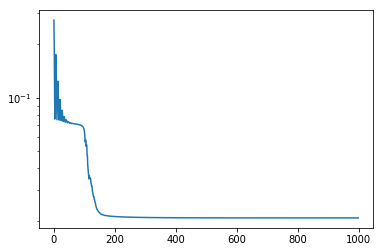

Error: 0.24614958


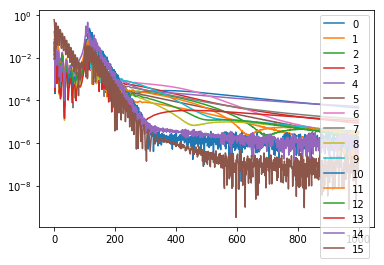

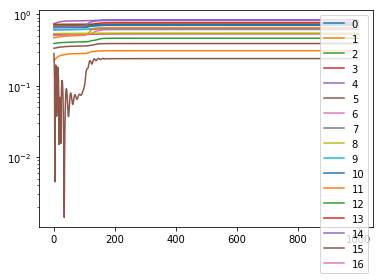

In [9]:
num_channels = [1]*15
net = decnet(1,num_channels,3,act_fun=None,mode="non-learned",res=False).type(dtype)

mse, ni, net, out_grads, out_norms = fit(net,y,num_channels,net_input = None,num_iter = 1000,LR = 0.1)

plt.semilogy(mse)
plt.show()

yy_np = net(ni).type(dtype).data.cpu().numpy()[0,0]
print("Error:", np.linalg.norm(yy_np - y_np)/np.linalg.norm(y_np) )
plot_gradients(out_grads)
plot_gradients(out_norms)

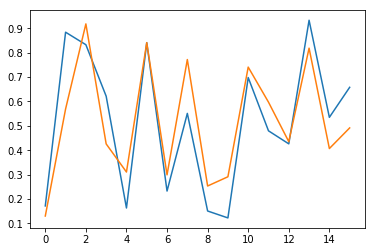

In [10]:
plt.plot(y_np)
plt.plot(yy_np)
plt.show()

input shape:  [1, 1, 16]
optimize with SGD 0.1


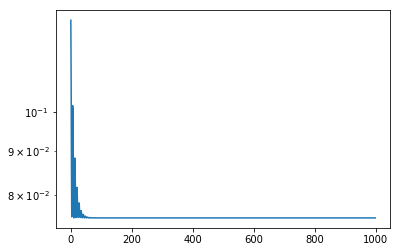

Error: 0.4675387


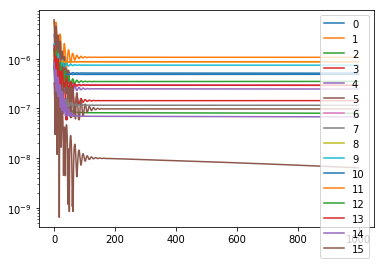

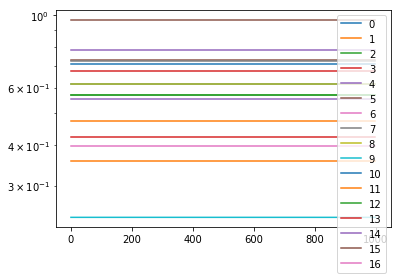

In [11]:
num_channels = [1]*15
net = decnet(1,num_channels,3,act_fun=None,mode="linear",res=False).type(dtype)

mse, ni, net, out_grads, out_norms = fit(net,y,num_channels,net_input = None,num_iter = 1000,LR = 0.1)

plt.semilogy(mse)
plt.show()

yy_np = net(ni).type(dtype).data.cpu().numpy()[0,0]
print("Error:", np.linalg.norm(yy_np - y_np)/np.linalg.norm(y_np) )
plot_gradients(out_grads)
plot_gradients(out_norms)

input shape:  [1, 1, 16]
optimize with SGD 0.1


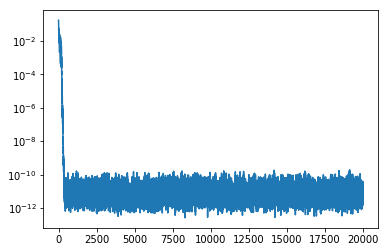

Error: 2.6728505e-06


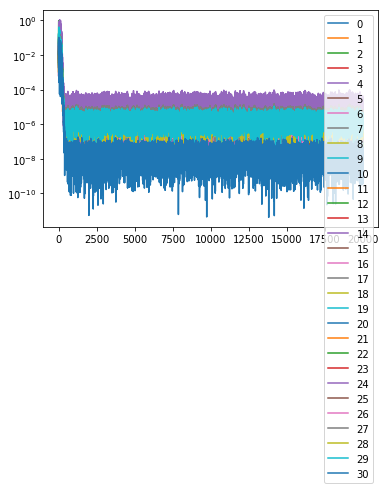

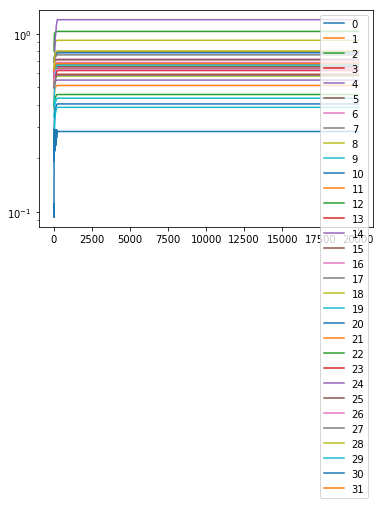

In [12]:
num_channels = [1]*30
net = decnet(1,num_channels,3,act_fun=None,mode="non-learned",res=False).type(dtype)

mse, ni, net, out_grads, out_norms = fit(net,y,num_channels,net_input = None,num_iter = 20000,LR = 0.1)

plt.semilogy(mse)
plt.show()

yy_np = net(ni).type(dtype).data.cpu().numpy()[0,0]
print("Error:", np.linalg.norm(yy_np - y_np)/np.linalg.norm(y_np) )
plot_gradients(out_grads)
plot_gradients(out_norms)

In [13]:
print_filters(net)

[[[0.11422025 0.35866028 0.5604967 ]]]
[[[ 0.04481462  0.51084006 -0.01856864]]]
[[[-0.04391986 -0.04502393  0.45227993]]]
[[[-0.5789563  -0.23639297 -0.14231068]]]
[[[-0.44194213  0.43998745  0.14376327]]]
[[[-0.53957814 -0.52818865 -0.23682858]]]
[[[ 0.58503306 -0.3208604   0.17799777]]]
[[[-0.01881256  0.24286531 -0.5883829 ]]]
[[[-0.68869156 -0.36881334 -0.4841413 ]]]
[[[ 0.13434795 -0.41295722 -0.03412989]]]
[[[-0.06912798  0.397944   -0.01830871]]]
[[[-0.6165541  -0.08994244 -0.10148671]]]
[[[-0.6548922   0.32333535 -0.7271519 ]]]
[[[0.49159864 0.33902705 0.17451192]]]
[[[0.574054   0.9461691  0.46229967]]]
[[[ 0.20760916  0.4708919  -0.4079103 ]]]
[[[-0.31399378  0.6479818   0.02711862]]]
[[[ 0.2553457   0.56435317 -0.44256908]]]
[[[0.53702456 0.17746666 0.1251727 ]]]
[[[-0.31429398  0.44673538 -0.38478848]]]
[[[-0.23865059 -0.6925412   0.27434728]]]
[[[ 0.37448102 -0.5470085  -0.1546843 ]]]
[[[0.52800196 0.22483273 0.13733874]]]
[[[-0.14474191 -0.5434543   0.18540226]]]
[[[-0.0

## Fitting a linear network without normalization

input shape:  [1, 1, 16]
optimize with SGD 0.1


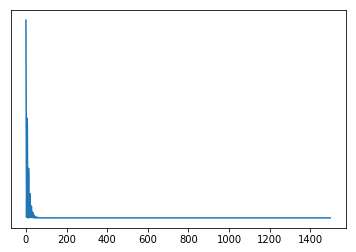

Error: 0.46753868


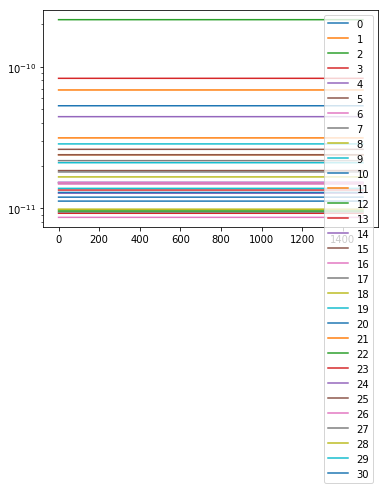

In [14]:
num_channels = [1]*30
net = decnet(1,num_channels,3,act_fun=None,mode="linear",res=False).type(dtype)

mse, ni, net, out_grads, out_norms = fit(net,y,num_channels,net_input = None,num_iter = 1500,LR = 0.1)

plt.semilogy(mse)
plt.show()

yy_np = net(ni).type(dtype).data.cpu().numpy()[0,0]
print("Error:", np.linalg.norm(yy_np - y_np)/np.linalg.norm(y_np) )
plot_gradients(out_grads)

## Fitting with centering

input shape:  [1, 1, 16]
optimize with SGD 0.1


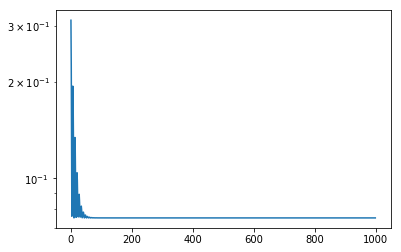

Error: 0.46753868


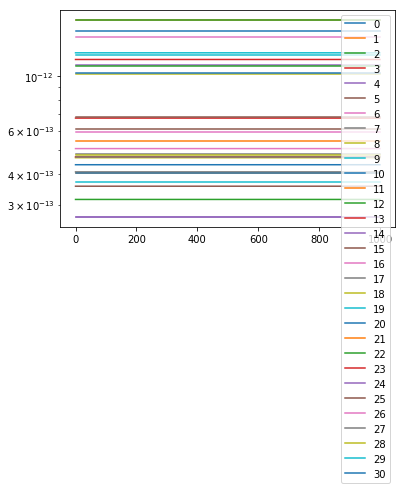

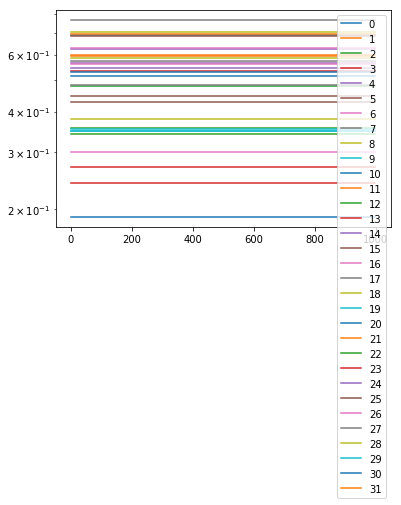

In [15]:
num_channels = [1]*30
net = decnet(1,num_channels,3,act_fun=None,res=False, mode="linear"#, modeout="normalize"
            ).type(dtype)

mse, ni, net, out_grads, out_norms = fit(net,y,num_channels,net_input = None,num_iter = 1000,LR = 0.1)

plt.semilogy(mse)
plt.show()

yy_np = net(ni).type(dtype).data.cpu().numpy()[0,0]
print("Error:", np.linalg.norm(yy_np - y_np)/np.linalg.norm(y_np) )
plot_gradients(out_grads)
plot_gradients(out_norms)

input shape:  [1, 1, 16]
optimize with SGD 0.1


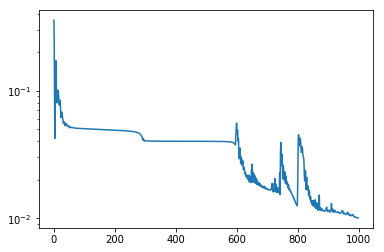

Error: 0.17071259


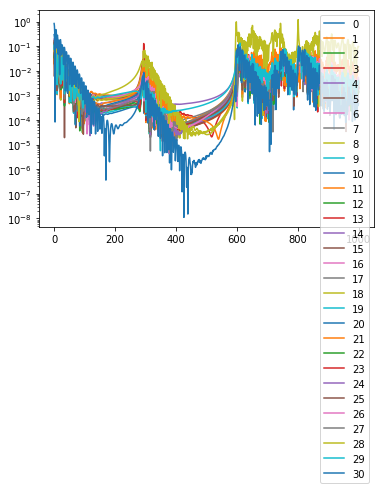

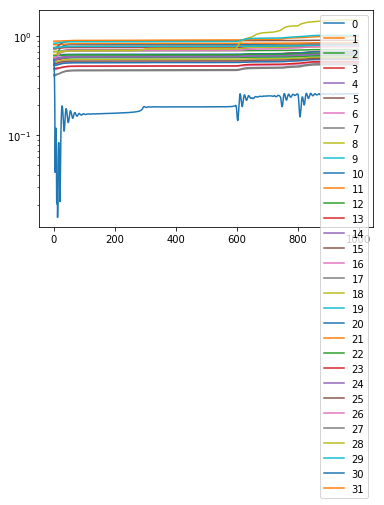

In [16]:
num_channels = [1]*30
net = decnet(1,num_channels,3,act_fun=None,res=False, mode="center", modeout="normalize").type(dtype)

mse, ni, net, out_grads, out_norms = fit(net,y,num_channels,net_input = None,num_iter = 1000,LR = 0.1)

plt.semilogy(mse)
plt.show()

yy_np = net(ni).type(dtype).data.cpu().numpy()[0,0]
print("Error:", np.linalg.norm(yy_np - y_np)/np.linalg.norm(y_np) )
plot_gradients(out_grads)
plot_gradients(out_norms)

# Res net

## linear 

input shape:  [1, 1, 16]
optimize with SGD 0.01


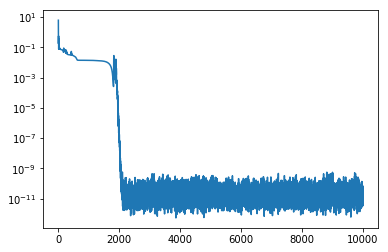

Error: 1.7029863e-05
Error: 1.7029863e-05


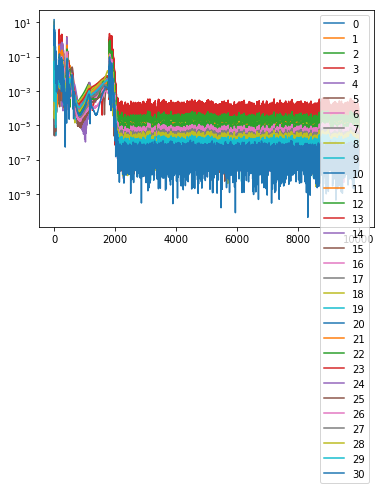

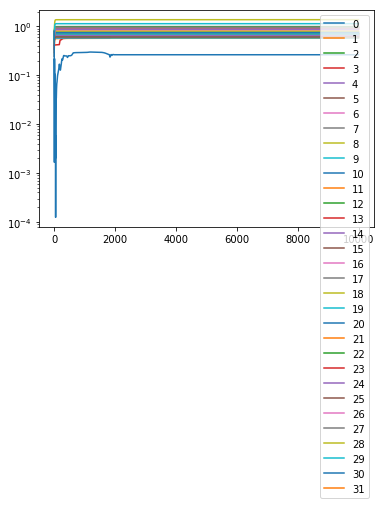

In [17]:
num_channels = [1]*30
net = decnet(1,num_channels,3,None,mode="linear",res=True).type(dtype)

mse, ni, net, out_grads, out_norms = fit(net,y,num_channels,net_input = None,num_iter = 10000,LR = 0.01)

yy = net(ni).type(dtype)
yy_np = yy.data.cpu().numpy()[0,0]

plt.semilogy(mse)
plt.show()

print("Error:", np.linalg.norm(yy_np - y_np)/np.linalg.norm(y_np) )

yy_np = net(ni).type(dtype).data.cpu().numpy()[0,0]
print("Error:", np.linalg.norm(yy_np - y_np)/np.linalg.norm(y_np) )
plot_gradients(out_grads)
plot_gradients(out_norms)

## BN

input shape:  [1, 1, 16]
optimize with SGD 0.01


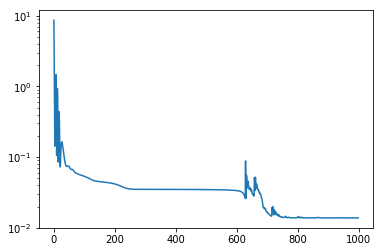

Error: 0.2003557
Error: 0.2003557


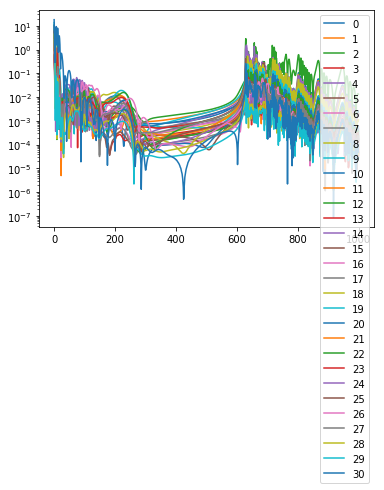

In [18]:
num_channels = [1]*30
net = decnet(1,num_channels,3,None,mode="non-learned",res=True).type(dtype)

mse, ni, net, out_grads, out_norms = fit(net,y,num_channels,net_input = None,num_iter = 1000,LR = 0.01)

yy = net(ni).type(dtype)
yy_np = yy.data.cpu().numpy()[0,0]

plt.semilogy(mse)
plt.show()

print("Error:", np.linalg.norm(yy_np - y_np)/np.linalg.norm(y_np) )

yy_np = net(ni).type(dtype).data.cpu().numpy()[0,0]
print("Error:", np.linalg.norm(yy_np - y_np)/np.linalg.norm(y_np) )
plot_gradients(out_grads)

# Highly overparameterized

In [19]:
n = 15
shape = [1,1,n]
y = Variable(torch.zeros(shape),requires_grad=False).type(dtype)
y.data.uniform_()
y_np = y.data.cpu().numpy()[0,0]

input shape:  [1, 1, 15]
optimize with SGD 0.01


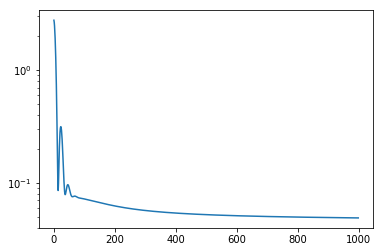

Error: 0.3970599


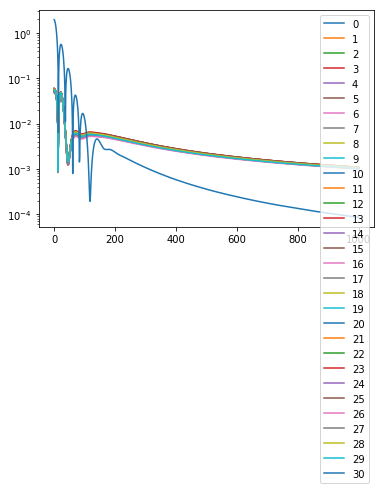

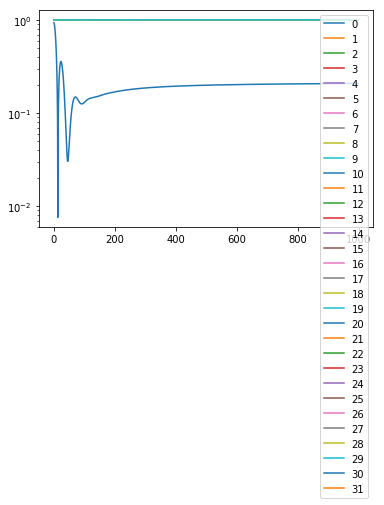

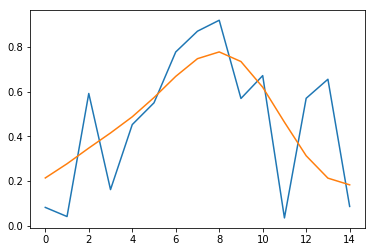

In [20]:
def uniform_initialize(net):
    for m in net.modules():
        if isinstance(m, nn.Conv1d):
            if m.weight.data.shape[2]>1:
                m.weight.data.uniform_()
                m.weight.data *= 0.1
                #m.weight.data[0,0,0] = 0
                m.weight.data[0,0,1] = 1
                #m.weight.data[0,0,2] = 0
                #m.weight.data[0,0,3] = 0
                #m.weight.data[0,0,4] = 0
                
num_channels = [1]*30
#net = decnet(1,num_channels,51,act_fun=None,res=False, mode="normalize", modeout="normalize").type(dtype)
net = decnet(1,num_channels,3,act_fun=None,res=False, mode= "non-learned",modeout="none").type(dtype)
net.apply( uniform_initialize )

mse, ni, net, out_grads, out_norms = fit(net,y,num_channels,net_input = None,num_iter = 1000,LR = 0.01)

plt.semilogy(mse)
plt.show()

yy_np = net(ni).type(dtype).data.cpu().numpy()[0,0]
print("Error:", np.linalg.norm(yy_np - y_np)/np.linalg.norm(y_np) )
plot_gradients(out_grads)
plot_gradients(out_norms)

plt.plot(y_np)
plt.plot(yy_np)
plt.show()

In [21]:
print(net)

Sequential(
  (1): Sequential(
    (0): Pad1d()
    (1): Conv1d(1, 1, kernel_size=(3,), stride=(1,), bias=False)
  )
  (2): ChannelNormalization()
  (3): Sequential(
    (0): Pad1d()
    (1): Conv1d(1, 1, kernel_size=(3,), stride=(1,), bias=False)
  )
  (4): ChannelNormalization()
  (5): Sequential(
    (0): Pad1d()
    (1): Conv1d(1, 1, kernel_size=(3,), stride=(1,), bias=False)
  )
  (6): ChannelNormalization()
  (7): Sequential(
    (0): Pad1d()
    (1): Conv1d(1, 1, kernel_size=(3,), stride=(1,), bias=False)
  )
  (8): ChannelNormalization()
  (9): Sequential(
    (0): Pad1d()
    (1): Conv1d(1, 1, kernel_size=(3,), stride=(1,), bias=False)
  )
  (10): ChannelNormalization()
  (11): Sequential(
    (0): Pad1d()
    (1): Conv1d(1, 1, kernel_size=(3,), stride=(1,), bias=False)
  )
  (12): ChannelNormalization()
  (13): Sequential(
    (0): Pad1d()
    (1): Conv1d(1, 1, kernel_size=(3,), stride=(1,), bias=False)
  )
  (14): ChannelNormalization()
  (15): Sequential(
    (0): Pad1d()
 